In [1]:
# !!! WATCH OUT S3 BUCKET PERMISSION !!!
# LOOK AT FILE INFO AT LAST

import boto3
import pandas as pd

___

#### Create s3 bucket, get object names in a bucket and send files to bucket.

In [2]:
client_s3 = boto3.client("s3")

Create an amazon s3 bucket

In [4]:
response = client_s3.create_bucket(ACL="private",Bucket="ingesting-data-super-heroes",
                                  CreateBucketConfiguration={"LocationConstraint":"us-east-2"},
                                  )

Read dataframes and look at dataframes.

In [10]:
df_info = pd.read_csv("heroes_information.csv",index_col=0)
df_power = pd.read_csv("super_hero_powers.csv")

In [11]:
df_info.head()

,name,Gender,Eye color,Race,Hair color,Height,Publisher,Skin color,Alignment,Weight
0,A-Bomb,Male,yellow,Human,No Hair,203.0,Marvel Comics,-,good,441.0
1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,blue,good,65.0
2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,red,good,90.0
3,Abomination,Male,green,Human / Radiation,No Hair,203.0,Marvel Comics,-,bad,441.0
4,Abraxas,Male,blue,Cosmic Entity,Black,-99.0,Marvel Comics,-,bad,-99.0


In [12]:
df_power.head()

,hero_names,Agility,Accelerated Healing,Lantern Power Ring,Dimensional Awareness,Cold Resistance,Durability,Stealth,Energy Absorption,Flight,...,Web Creation,Reality Warping,Odin Force,Symbiote Costume,Speed Force,Phoenix Force,Molecular Dissipation,Vision - Cryo,Omnipresent,Omniscient
0,3-D Man,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,A-Bomb,False,True,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Abe Sapien,True,True,False,False,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Abin Sur,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Abomination,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Get objects from a bucket

In [20]:
bucket_name = "yunusbucket"
bucket_objects = client_s3.list_objects(Bucket=bucket_name)

print(f"There are {len(bucket_objects['Contents'])} objects.")
object_names = [i["Key"] for i in bucket_objects["Contents"]]
object_names[:4]

Send files to a bucket.

In [58]:
file_paths = ["heroes_information.csv","super_hero_powers.csv"]
file_names = ["df_info.csv","df_power.csv"]
bucket_name = "ingesting-data-super-heroes"
bucket_objects = client_s3.list_objects(Bucket=bucket_name)
for file_path,file_name in zip(file_paths,file_names):
    try:
        object_names = [i["Key"] for i in bucket_objects["Contents"]]
        if file_name in object_names:
            pass
        else:
            client_s3.upload_file(file_path, bucket_name, file_name)
    except:
        client_s3.upload_file(file_path, bucket_name, file_name)

___

In [2]:
# I connected athena with s3 bucket. "ingesting-data-super-heroes"

client_athena = boto3.client("athena")

Look at data catalogs and databases.

In [18]:
# client_athena.meta.region_name

data_catalogs = client_athena.list_data_catalogs()
catalog_names = [i["CatalogName"] for i in data_catalogs["DataCatalogsSummary"]]
print(f"Catalog names => {catalog_names}")

Catalog names => ['AwsDataCatalog']


In [24]:
databases = client_athena.list_databases(CatalogName="AwsDataCatalog")
database_names = [i["Name"] for i in databases["DatabaseList"]]
print(f"Database names => {database_names}")

Database names => ['default']


Create database and table on Athena

In [ ]:
s3_location = "s3://ingesting-data-super-heroes/"
query = "CREATE DATABASE super_heroes_db"
response = client_athena.start_query_execution(QueryString=query,
                                    ResultConfiguration={"OutputLocation":s3_location})

In [29]:
# Check whether db is created or not.

databases = client_athena.list_databases(CatalogName="AwsDataCatalog")
database_names = [i["Name"] for i in databases["DatabaseList"]]
print(f"Database names => {database_names}")

Database names => ['default', 'super_heroes_db']


In [3]:
# Create table on Athena

query = "CREATE EXTERNAL TABLE IF NOT EXISTS test_table(\
  column1 int)\
LOCATION 's3://ingesting-data-super-heroes/'"
s3_location = "s3://ingesting-data-super-heroes/"
database_name = "super_heroes_db"
catalog_name = "AwsDataCatalog"
response = client_athena.start_query_execution(QueryString=query,
                                    QueryExecutionContext={"Database":database_name,
                                                          "Catalog":catalog_name},
                                    ResultConfiguration={"OutputLocation":s3_location})

Database and table automatically created in AWS Glue Data Catalog as we see below.

In [4]:
client_glue = boto3.client("glue")

In [5]:
# Database names

db_glue = client_glue.get_databases()
[i["Name"] for i in db_glue["DatabaseList"]]

['default', 'super_heroes_db']

In [6]:
# Table names in the db.

table_glue = client_glue.get_tables(DatabaseName="super_heroes_db")
[i["Name"] for i in table_glue["TableList"]]

['test_table']

___

#### Create table on Athena from dataframe.

In [8]:
df_info = pd.read_csv("heroes_information.csv",index_col=0)
df_power = pd.read_csv("super_hero_powers.csv")

In [45]:
df_info.rename(columns={"Gender":"gender","Eye color":"eye_color","Race":"race","Hair color":"hair_color",
                       "Height":"height","Publisher":"publisher","Skin color":"skin_color",
                        "Alignment":"alignment","Weight":"weight"}, inplace=True)
df_info.head(3)

,name,gender,eye_color,race,hair_color,height,publisher,skin_color,alignment,weight
0,A-Bomb,Male,yellow,Human,No Hair,203.0,Marvel Comics,-,good,441.0
1,Abe Sapien,Male,blue,Icthyo Sapien,No Hair,191.0,Dark Horse Comics,blue,good,65.0
2,Abin Sur,Male,blue,Ungaran,No Hair,185.0,DC Comics,red,good,90.0


In [50]:
query = """CREATE TABLE super_heroes_table(name string,  gender string,  eye_color string,  race string,  
hair_color string, height float,  publisher string,  skin_color string,  alignment string,  weight float)
ROW FORMAT SERDE 'org.apache.hadoop.hive.serde2.lazy.LazySimpleSerDe' 
WITH SERDEPROPERTIES ('serialization.format' = ',', 'field.delim' = ',') 
LOCATION 's3://ingesting-data-super-heroes/csv_file/'
TBLPROPERTIES ('has_encrypted_data'='false','skip.header.line.count'='1')"""

s3_location = "s3://ingesting-data-super-heroes/athena-output/"
database_name = "super_heroes_db"
catalog_name = "AwsDataCatalog"
response = client_athena.start_query_execution(QueryString=query,
                                    QueryExecutionContext={"Database":database_name,
                                                          "Catalog":catalog_name},
                                    ResultConfiguration={"OutputLocation":s3_location})

Query on the table and get query results.

In [51]:
query = """SELECT * FROM super_heroes_table LIMIT 5"""

s3_location = "s3://ingesting-data-super-heroes/athena-output/"
database_name = "super_heroes_db"
catalog_name = "AwsDataCatalog"
response = client_athena.start_query_execution(QueryString=query,
                                    QueryExecutionContext={"Database":database_name,
                                                          "Catalog":catalog_name},
                                    ResultConfiguration={"OutputLocation":s3_location})

In [52]:
query_result = client_athena.get_query_results(QueryExecutionId=response["QueryExecutionId"])

In [77]:
# Columns.
query_result["ResultSet"]["Rows"][0]

# Data values variables.
print("First row values ->")
print(list([variable["VarCharValue"] for variable in query_result["ResultSet"]["Rows"][3]["Data"]]))

First row values ->
['Abin Sur', 'Male', 'blue', 'Ungaran', 'No Hair', '185.0', 'DC Comics', 'red', 'good', '90.0']


#### Creating parquet-based table.

In [6]:
# Be sure that athena-parquet file is empty.

query = """create table if not exists super_heroes_db.super_heroes_parquet 
with (format='PARQUET', external_location='s3://ingesting-data-super-heroes/athena-parquet/', 
partitioned_by=array['publisher']) as 
select name, gender, eye_color, race, hair_color, height, skin_color, alignment, weight,
publisher from super_heroes_table"""

s3_location = "s3://ingesting-data-super-heroes/athena-parquet/"
database_name = "super_heroes_db"
catalog_name = "AwsDataCatalog"
response = client_athena.start_query_execution(QueryString=query,
                                    QueryExecutionContext={"Database":database_name,
                                                          "Catalog":catalog_name},
                                    ResultConfiguration={"OutputLocation":s3_location})

In [7]:
query = """msck repair table super_heroes_parquet"""

s3_location = "s3://ingesting-data-super-heroes/athena-parquet/"
database_name = "super_heroes_db"
catalog_name = "AwsDataCatalog"
response = client_athena.start_query_execution(QueryString=query,
                                    QueryExecutionContext={"Database":database_name,
                                                          "Catalog":catalog_name},
                                    ResultConfiguration={"OutputLocation":s3_location})

In [11]:
query = """select * from super_heroes_parquet where publisher='Marvel Comics' limit 5"""

s3_location = "s3://ingesting-data-super-heroes/athena-parquet/"
database_name = "super_heroes_db"
catalog_name = "AwsDataCatalog"
response = client_athena.start_query_execution(QueryString=query,
                                    QueryExecutionContext={"Database":database_name,
                                                          "Catalog":catalog_name},
                                    ResultConfiguration={"OutputLocation":s3_location})

In [12]:
query_result = client_athena.get_query_results(QueryExecutionId=response["QueryExecutionId"])

In [13]:
query_result

{'UpdateCount': 0,
 'ResultSet': {'Rows': [{'Data': [{'VarCharValue': 'name'},
     {'VarCharValue': 'gender'},
     {'VarCharValue': 'eye_color'},
     {'VarCharValue': 'race'},
     {'VarCharValue': 'hair_color'},
     {'VarCharValue': 'height'},
     {'VarCharValue': 'skin_color'},
     {'VarCharValue': 'alignment'},
     {'VarCharValue': 'weight'},
     {'VarCharValue': 'publisher'}]},
   {'Data': [{'VarCharValue': 'A-Bomb'},
     {'VarCharValue': 'Male'},
     {'VarCharValue': 'yellow'},
     {'VarCharValue': 'Human'},
     {'VarCharValue': 'No Hair'},
     {'VarCharValue': '203.0'},
     {'VarCharValue': '-'},
     {'VarCharValue': 'good'},
     {'VarCharValue': '441.0'},
     {'VarCharValue': 'Marvel Comics'}]},
   {'Data': [{'VarCharValue': 'Abomination'},
     {'VarCharValue': 'Male'},
     {'VarCharValue': 'green'},
     {'VarCharValue': 'Human / Radiation'},
     {'VarCharValue': 'No Hair'},
     {'VarCharValue': '203.0'},
     {'VarCharValue': '-'},
     {'VarCharValue': 'b

#### Without moving data to warehouse query s3 data from Amazon Redshift

In [22]:
# Give glue data catalog access to redshift iam role.

client_redshift = boto3.client("redshift")

In [26]:
client_redshift_data = boto3.client("redshift-data")

In [30]:
cluster = client_redshift.describe_clusters()

In [34]:
cluster["Clusters"][0]["ClusterIdentifier"]

'redshift-cluster-1'

Print schemas

In [36]:
cluster_identifier = "redshift-cluster-1"
connected_db = "dev"
db_user = "awsuser"

In [45]:
schemas = client_redshift_data.list_schemas(ClusterIdentifier=cluster_identifier,Database=connected_db,
                                 DbUser=db_user)

tables = client_redshift_data.list_tables(ClusterIdentifier=cluster_identifier,Database=connected_db,
                                 DbUser=db_user)

In [63]:
schemas["Schemas"]

['athena',
 'catalog_history',
 'information_schema',
 'pg_catalog',
 'pg_internal',
 'public',
 'redshift_schema']

In [62]:
[i["name"] for i in tables["Tables"] if i["schema"]=="athena"]

['super_heroes_parquet', 'super_heroes_table', 'test_table']

___

This part implemented on aws console.

In [77]:
cluster_identifier = "redshift-cluster-1"
connected_db = "dev"
db_user = "awsuser"
# IAM Role
secret_arn = 'arn:aws:iam::........:role/service-role/AmazonRedshift-CommandsAccessRole-......'
sql_query = """create external schema if not exists athena from data catalog 
database 'super_heroes_db' 
iam_role 'arn:aws:iam::.....:role/service-role/AmazonRedshift-CommandsAccessRole-....' 
create external database if not exists"""

In [81]:
response = client_redshift_data.batch_execute_statement(ClusterIdentifier=cluster_identifier, Database=connected_db,
                                       DbUser=db_user, Sqls=[sql_query])

Steps

Create schema named athena and get data from super_heroes_db

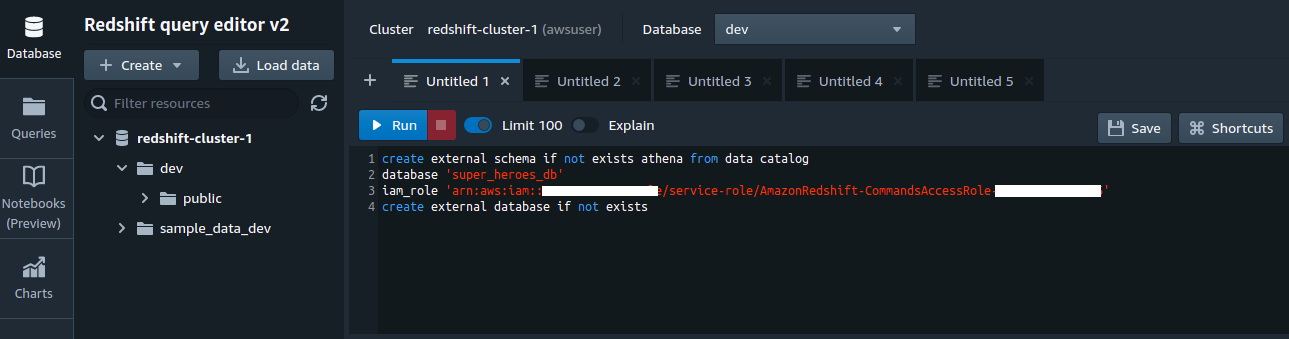

Print table

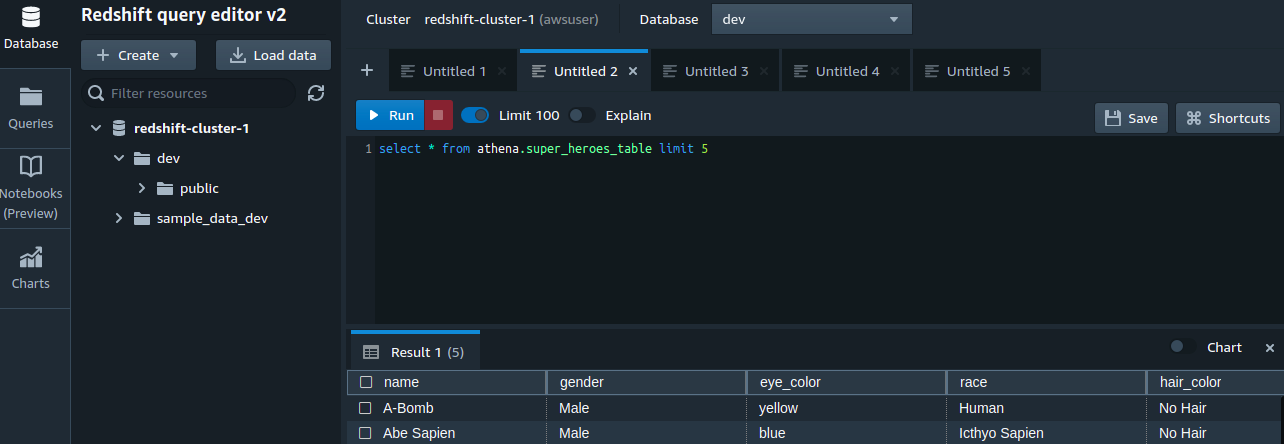

Create schema named redshift_schema

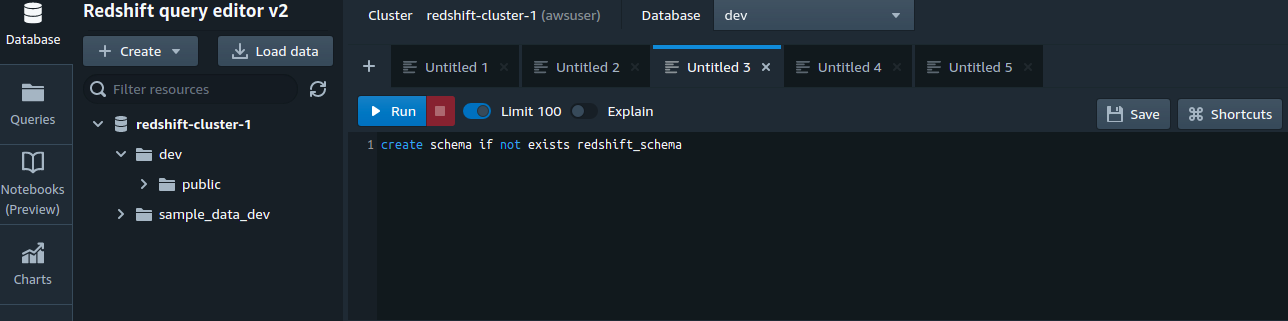

Create a table

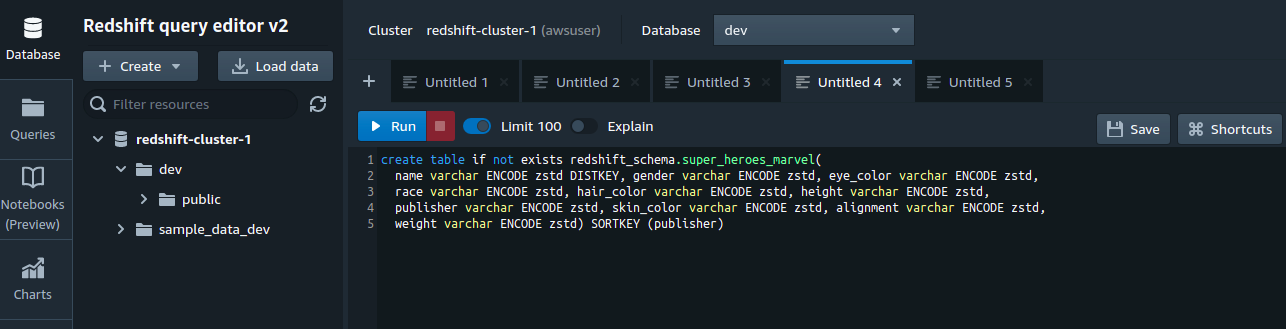

Move data from an existing table to the new created table

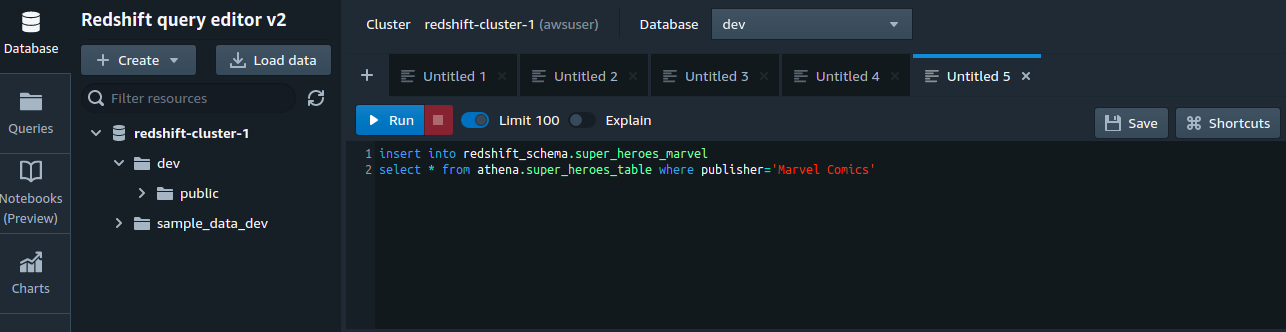

Send data from redshift to s3 data lake

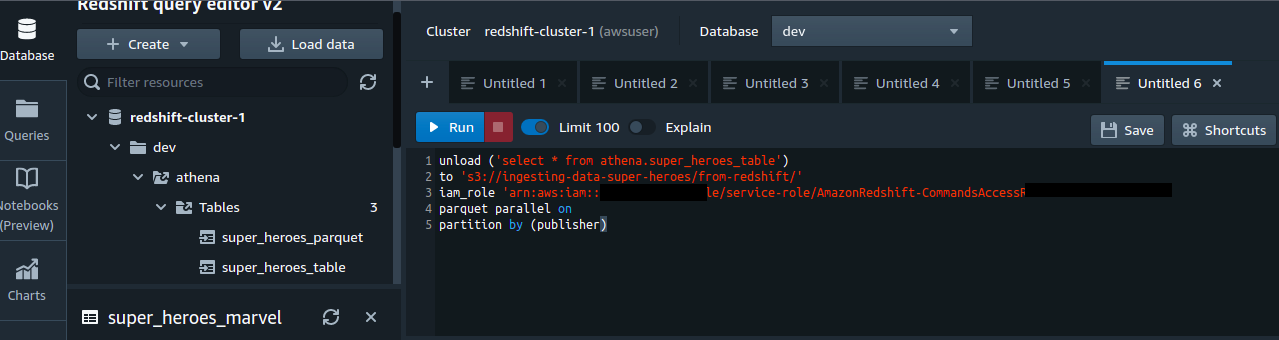

csv_file contains csv file you want to read.

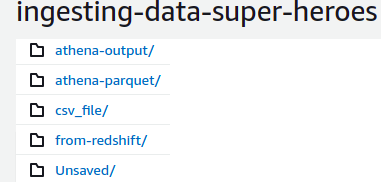